# Case Study - Analyse and predict the data of the hourly vehicle counts of particular highway in the year of 1995 beginning from the month of August.

**Importing Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

**Importing the Dataset**

In [2]:
df = pd.read_csv("Vehicle.csv")

**Examining the Dataset**

In [3]:
df.head()

,Hour,Vehicles
0,1,699
1,2,346
2,3,193
3,4,191
4,5,193


In [4]:
df.tail()

,Hour,Vehicles
1684,1685,194
1685,1686,373
1686,1687,1218
1687,1688,4076
1688,1689,5137


In [5]:
df.shape

(1689, 2)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Hour      1689 non-null   int64
 1   Vehicles  1689 non-null   int64
dtypes: int64(2)
memory usage: 26.5 KB


We can see that the dataset goes from hour 1 to hour 1689. This is the only column besides the number of vehicles variable.  We can change this to a date stamp based on the hour, starting on August 1st, 1995 at midnight 

In [12]:
date = pd.date_range(start='1/1/1985', end='1/1/1990', freq='Q')
date

DatetimeIndex(['1985-03-31', '1985-06-30', '1985-09-30', '1985-12-31',
               '1986-03-31', '1986-06-30', '1986-09-30', '1986-12-31',
               '1987-03-31', '1987-06-30', '1987-09-30', '1987-12-31',
               '1988-03-31', '1988-06-30', '1988-09-30', '1988-12-31',
               '1989-03-31', '1989-06-30', '1989-09-30', '1989-12-31'],
              dtype='datetime64[ns]', freq='Q-DEC')

In [7]:
date = pd.date_range(start='8/1/1995',freq='H',periods=1689)
date

DatetimeIndex(['1995-08-01 00:00:00', '1995-08-01 01:00:00',
               '1995-08-01 02:00:00', '1995-08-01 03:00:00',
               '1995-08-01 04:00:00', '1995-08-01 05:00:00',
               '1995-08-01 06:00:00', '1995-08-01 07:00:00',
               '1995-08-01 08:00:00', '1995-08-01 09:00:00',
               ...
               '1995-10-09 23:00:00', '1995-10-10 00:00:00',
               '1995-10-10 01:00:00', '1995-10-10 02:00:00',
               '1995-10-10 03:00:00', '1995-10-10 04:00:00',
               '1995-10-10 05:00:00', '1995-10-10 06:00:00',
               '1995-10-10 07:00:00', '1995-10-10 08:00:00'],
              dtype='datetime64[ns]', length=1689, freq='H')

In [8]:
df['Time_Stamp'] = pd.to_datetime(date,yearfirst=False,dayfirst=False,format="%")
df.head()

,Hour,Vehicles,Time_Stamp
0,1,699,1995-08-01 00:00:00
1,2,346,1995-08-01 01:00:00
2,3,193,1995-08-01 02:00:00
3,4,191,1995-08-01 03:00:00
4,5,193,1995-08-01 04:00:00


Once the time stamp is in place, we can drop the Hour column and set the Time Stamp column as the index.

In [10]:
df.drop(labels='Hour',axis=1,inplace=True)

In [11]:
df.set_index(keys='Time_Stamp',drop=True,inplace=True)
df.head()

,Vehicles
Time_Stamp,
1995-08-01 00:00:00,699
1995-08-01 01:00:00,346
1995-08-01 02:00:00,193
1995-08-01 03:00:00,191
1995-08-01 04:00:00,193


## Plotting the Data

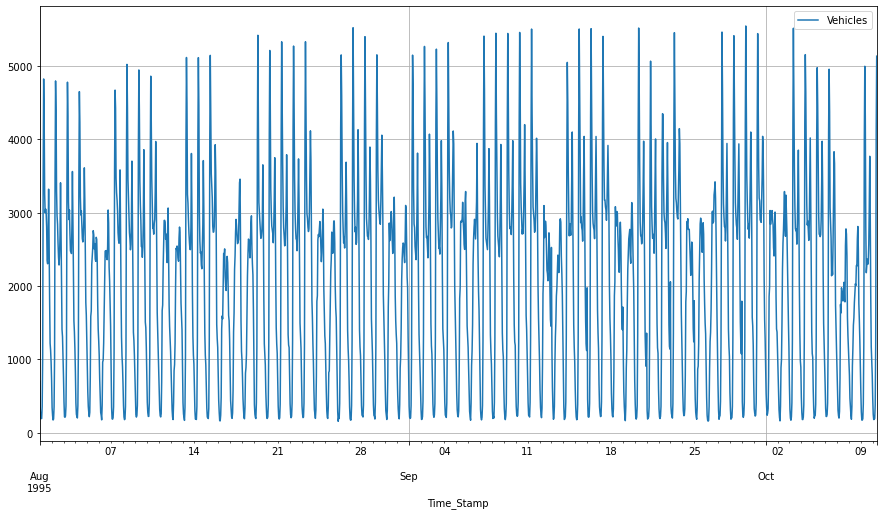

In [12]:
rcParams['figure.figsize'] = 15,8
df.plot()
plt.grid();

From the above graph, we can see that there is a seasonal component, with peaks around the end of first quarter and troughs around the end of the third quarter. We can also see a trend upwards in year over year shipping. 

In [13]:
df.describe()

,Vehicles
count,1689.000000
mean,2060.417999
std,1339.545842
min,154.000000
25%,851.000000
50%,2262.000000
75%,2924.000000
max,5549.000000


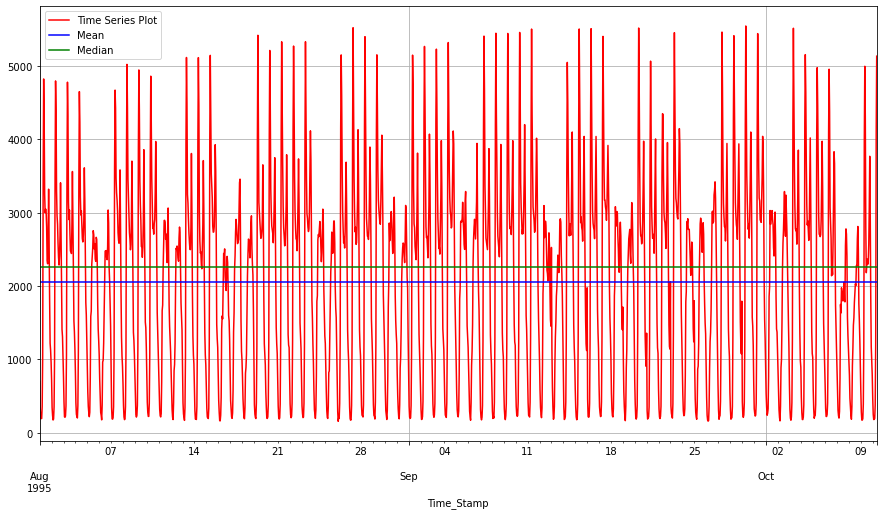

In [15]:
df.plot(color='Red')
plt.axhline(df['Vehicles'].mean(),color='Blue')
plt.axhline(df['Vehicles'].median(),color='Green')
plt.grid()
plt.legend(['Time Series Plot','Mean','Median']);

Plotting the time series along with the median and mean values shows the fluctuations in the data

**Decomposing the data**

We know from the above plots that there is a seasonal as well as year over year trend in the data.  We can decompose the data to examine these features more closely.

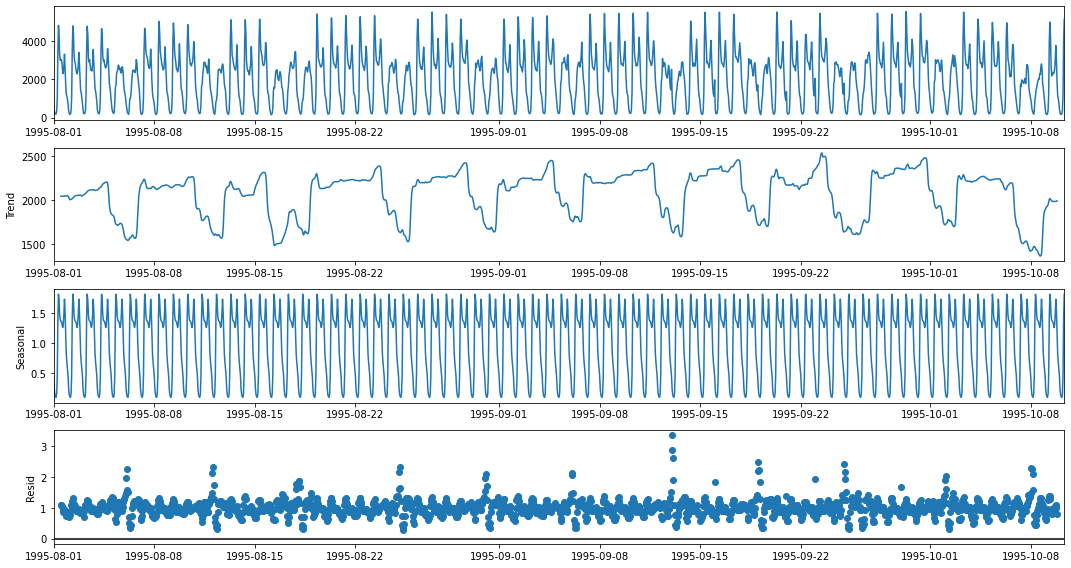

In [16]:
decomposition = seasonal_decompose(df,model='multiplicative')
decomposition.plot();

In [17]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

In [18]:
print('Trend','\n',trend,'\n')
print('Seasonality','\n',seasonality,'\n')
print('Residual','\n',residual,'\n')

Trend 
 Time_Stamp
1995-08-01 00:00:00   NaN
1995-08-01 01:00:00   NaN
1995-08-01 02:00:00   NaN
1995-08-01 03:00:00   NaN
1995-08-01 04:00:00   NaN
                       ..
1995-10-10 04:00:00   NaN
1995-10-10 05:00:00   NaN
1995-10-10 06:00:00   NaN
1995-10-10 07:00:00   NaN
1995-10-10 08:00:00   NaN
Name: trend, Length: 1689, dtype: float64 

Seasonality 
 Time_Stamp
1995-08-01 00:00:00    0.455006
1995-08-01 01:00:00    0.239579
1995-08-01 02:00:00    0.146309
1995-08-01 03:00:00    0.112478
1995-08-01 04:00:00    0.103107
                         ...   
1995-10-10 04:00:00    0.103107
1995-10-10 05:00:00    0.159886
1995-10-10 06:00:00    0.468012
1995-10-10 07:00:00    1.424237
1995-10-10 08:00:00    1.806399
Name: seasonal, Length: 1689, dtype: float64 

Residual 
 Time_Stamp
1995-08-01 00:00:00   NaN
1995-08-01 01:00:00   NaN
1995-08-01 02:00:00   NaN
1995-08-01 03:00:00   NaN
1995-08-01 04:00:00   NaN
                       ..
1995-10-10 04:00:00   NaN
1995-10-10 05:00:00   N

### Split the data into train and test and plot the training and test data

In [19]:
train = df[0:int(len(df)*0.7)] 
test = df[int(len(df)*0.7):]

In [20]:
print(train.shape)
print(test.shape)

(1182, 1)
(507, 1)


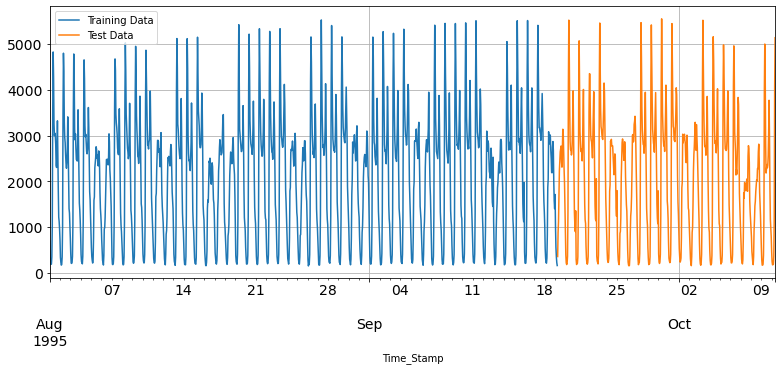

In [21]:
train['Vehicles'].plot(figsize=(13,5), fontsize=14)
test['Vehicles'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

**Model 1: Build a Linear Regression using the Time Stamped order of occurence of the vehicle count**

In [22]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+1183 for i in range(len(test))]
print('Training Time instance','\n',train_time)
print('Test Time instance','\n',test_time)

Training Time instance 
 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 21

In [23]:
LinearRegression_train = train.copy()
LinearRegression_test = test.copy()

In [24]:
LinearRegression_train['time'] = train_time
LinearRegression_test['time'] = test_time

In [25]:
lr = LinearRegression()

In [26]:
lr.fit(LinearRegression_train[['time']],LinearRegression_train['Vehicles'].values)

LinearRegression()

In [27]:
test_predictions_model1 = lr.predict(LinearRegression_test[['time']])
LinearRegression_test['RegOnTime'] = test_predictions_model1

In [30]:
rmse_model1_test = metrics.mean_squared_error(test['Vehicles'],test_predictions_model1,squared=False)
print("RMSE equals %3.3f" %(rmse_model1_test))

RMSE equals 1362.674


In [29]:
resultsDf = pd.DataFrame({'Test RMSE': [rmse_model1_test]},index=['RegressionOnTime'])
resultsDf

,Test RMSE
RegressionOnTime,1362.674158


**Model 2: Build a Simple Exponential Smoothing model by using the parameter 'optimise=True' within the '.fit()' function. Then,evaluate the same model on the test set using RMSE**

In [31]:
SES_train = train.copy()
SES_test = test.copy()

In [32]:
model_SES = SimpleExpSmoothing(SES_train['Vehicles'])

C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [33]:
model_SES_autofit = model_SES.fit(optimized=True,use_brute=True)

C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [34]:
model_SES_autofit.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 699.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [35]:
test_predictions_model2 = model_SES_autofit.forecast(steps=len(test))
test_predictions_model2

1995-09-19 06:00:00    163.318201
1995-09-19 07:00:00    163.318201
1995-09-19 08:00:00    163.318201
1995-09-19 09:00:00    163.318201
1995-09-19 10:00:00    163.318201
                          ...    
1995-10-10 04:00:00    163.318201
1995-10-10 05:00:00    163.318201
1995-10-10 06:00:00    163.318201
1995-10-10 07:00:00    163.318201
1995-10-10 08:00:00    163.318201
Freq: H, Length: 507, dtype: float64

In [36]:
rmse_model2_test = metrics.mean_squared_error(test['Vehicles'],test_predictions_model2,squared=False)
print("RMSE equals %3.3f" %(rmse_model2_test))

RMSE equals 2322.774


In [37]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse_model2_test]}
                              ,index=['Alpha=0.995:SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,Test RMSE
RegressionOnTime,1362.674158
Alpha=0.995:SimpleExponentialSmoothing,2322.773950


**Model 3: Build a Double Exponential Smoothing model by using the parameter 'optimise=True' within the '.fit()' function. Then,evaluate the same model on the test set using RMSE**

In [38]:
DES_train = train.copy()
DES_test = test.copy()

In [39]:
model_DES = Holt(SES_train['Vehicles'])

C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [40]:
model_DES_autofit = model_DES.fit(optimized=True,use_brute=True)

C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [41]:
model_DES_autofit.params_formatted

,name,param,optimized
smoothing_level,alpha,0.995,True
smoothing_trend,beta,0.995,True
initial_level,l.0,699.000,True
initial_trend,b.0,-353.000,True


In [42]:
test_predictions_model3 = model_DES_autofit.forecast(steps=len(test))
test_predictions_model3

1995-09-19 06:00:00       99.451324
1995-09-19 07:00:00       36.222309
1995-09-19 08:00:00      -27.006706
1995-09-19 09:00:00      -90.235721
1995-09-19 10:00:00     -153.464736
                           ...     
1995-10-10 04:00:00   -31641.514216
1995-10-10 05:00:00   -31704.743231
1995-10-10 06:00:00   -31767.972246
1995-10-10 07:00:00   -31831.201261
1995-10-10 08:00:00   -31894.430276
Freq: H, Length: 507, dtype: float64

In [43]:
rmse_model3_test = metrics.mean_squared_error(test['Vehicles'],test_predictions_model3,squared=False)
print("RMSE equals %3.3f" %(rmse_model3_test))

RMSE equals 20198.794


In [44]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse_model3_test]}
                              ,index=['Alpha=0.995,Beta=0.995:DoubleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,Test RMSE
RegressionOnTime,1362.674158
Alpha=0.995:SimpleExponentialSmoothing,2322.773950
"Alpha=0.995,Beta=0.995:DoubleExponentialSmoothing",20198.794201


**Model 4: Build a Triple Exponential Smoothing model by using the parameter 'optimise=True' within the '.fit()' function. Then,evaluate the same model on the test set using RMSE.**

In [45]:
TES_train = train.copy()
TES_test = test.copy()

In [46]:
model_TES = ExponentialSmoothing(SES_train['Vehicles'],trend='additive',seasonal='multiplicative')

C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [47]:
model_TES_autofit = model_TES.fit(optimized=True,use_brute=True)

C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [48]:
model_TES_autofit.params

{'smoothing_level': 0.995,
 'smoothing_trend': 0.0001,
 'smoothing_seasonal': 0.0050000000000000044,
 'damping_trend': nan,
 'initial_level': 892.54,
 'initial_trend': 0.15972222222222202,
 'initial_seasons': array([0.78315818, 0.3876577 , 0.21623681, 0.21399601, 0.21623681,
        0.39774128, 1.14392632, 3.88890134, 5.40704058, 4.79978488,
        3.64465458, 3.3611939 , 3.41945459, 3.36679589, 3.14831828,
        2.63405562, 2.58139691, 2.9724158 , 3.72196204, 2.86037601,
        2.02904072, 1.36688552, 1.25820692, 1.07222085]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [49]:
test_predictions_model4 = model_TES_autofit.forecast(steps=len(test))
test_predictions_model4

1995-09-19 06:00:00     481.366905
1995-09-19 07:00:00    1598.544019
1995-09-19 08:00:00    2228.671655
1995-09-19 09:00:00    2085.540403
1995-09-19 10:00:00    1617.325461
                          ...     
1995-10-10 04:00:00      99.676427
1995-10-10 05:00:00     182.667539
1995-10-10 06:00:00     535.304736
1995-10-10 07:00:00    1777.623287
1995-10-10 08:00:00    2478.286424
Freq: H, Length: 507, dtype: float64

In [50]:
rmse_model4_test = metrics.mean_squared_error(test['Vehicles'],test_predictions_model4,squared=False)
print("RMSE equals %3.3f" %(rmse_model4_test))

RMSE equals 1337.622


In [51]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [rmse_model4_test]}
                              ,index=['Alpha=0.99,Beta=0.0001,Gamma=0.005:DoubleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,Test RMSE
RegressionOnTime,1362.674158
Alpha=0.995:SimpleExponentialSmoothing,2322.773950
"Alpha=0.995,Beta=0.995:DoubleExponentialSmoothing",20198.794201
"Alpha=0.99,Beta=0.0001,Gamma=0.005:DoubleExponentialSmoothing",1337.621508


**Model 5: Build a Simple Exponential Smoothing model by taking the best alpha [in the range of 0.01 to 1 taking an interval of 0.01] in terms of the least RMSE. Then,evaluate the same model on the test data. Also, do make sure that 'optimized = False' within the '.fit()' command**

In [52]:
resultsDf_model = pd.DataFrame({'Alpha Values':[],'Test RMSE': []})
resultsDf_model

,Alpha Values,Test RMSE


In [53]:
for i in np.arange(0.01,1,0.01):
    model_SES_alpha_i = model_SES.fit(smoothing_level=i,optimized=False,use_brute=True)
    SES_test['predict',i] = model_SES_alpha_i.forecast(steps=len(test))
    
    rmse_model2_test_i = metrics.mean_squared_error(SES_test['Vehicles'],SES_test['predict',i],squared=False)
    
    resultsDf_model = resultsDf_model.append({'Alpha Values':i
                                              ,'Test RMSE':rmse_model2_test_i}, ignore_index=True)

In [54]:
resultsDf_model

,Alpha Values,Test RMSE
0,0.01,1351.375229
1,0.02,1350.523209
2,0.03,1354.426401
3,0.04,1364.089357
4,0.05,1378.518123
...,...,...
94,0.95,2320.188858
95,0.96,2320.805848
96,0.97,2321.397448
97,0.98,2321.965005


In [55]:
resultsDf_model.sort_values(by=['Test RMSE'],ascending=True)

,Alpha Values,Test RMSE
1,0.02,1350.523209
0,0.01,1351.375229
2,0.03,1354.426401
3,0.04,1364.089357
4,0.05,1378.518123
...,...,...
94,0.95,2320.188858
95,0.96,2320.805848
96,0.97,2321.397448
97,0.98,2321.965005


In [56]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [resultsDf_model.sort_values(by=['Test RMSE'],ascending=True).values[0][1]]}
                              ,index=['Alpha=0.02,SimpleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,Test RMSE
RegressionOnTime,1362.674158
Alpha=0.995:SimpleExponentialSmoothing,2322.773950
"Alpha=0.995,Beta=0.995:DoubleExponentialSmoothing",20198.794201
"Alpha=0.99,Beta=0.0001,Gamma=0.005:DoubleExponentialSmoothing",1337.621508
"Alpha=0.02,SimpleExponentialSmoothing",1350.523209


**Model 6: Build a Double Exponential Smoothing model by taking the best alpha and beta [both in the range of 0.01 to 1 taking an interval of 0.01] in terms of the least RMSE. Then,evaluate the same model on the test data. Also, do make sure that 'optimized = False' within the '.fit()' command**

In [57]:
DES_train = train.copy()
DES_test = test.copy()

In [58]:
model_DES = Holt(DES_train['Vehicles'])

C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
C:\Users\mulli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [59]:
resultsDf_model = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Test RMSE': []})
resultsDf_model

,Alpha Values,Beta Values,Test RMSE


In [60]:
for i in np.arange(0.01,1,0.01):
    for j in np.arange(0.01,1,0.01):
        model_DES_alpha_i_j = model_DES.fit(smoothing_level=i,smoothing_trend=j,optimized=False,use_brute=True)
        DES_test['predict',i,j] = model_DES_alpha_i_j.forecast(steps=len(test))
        
        
        rmse_model4_test = metrics.mean_squared_error(DES_test['Vehicles'],DES_test['predict',i,j],squared=False)
        
        resultsDf_model = resultsDf_model.append({'Alpha Values':i,'Beta Values':j
                                          ,'Test RMSE':rmse_model4_test}, ignore_index=True)

In [61]:
resultsDf_model

,Alpha Values,Beta Values,Test RMSE
0,0.01,0.01,1389.929814
1,0.01,0.02,1351.890036
2,0.01,0.03,1439.111357
3,0.01,0.04,1347.656134
4,0.01,0.05,1472.106141
...,...,...,...
9796,0.99,0.95,21032.747938
9797,0.99,0.96,20828.343656
9798,0.99,0.97,20631.029075
9799,0.99,0.98,20440.277273


In [62]:
resultsDf_model.sort_values(by=['Test RMSE'],ascending=True)

,Alpha Values,Beta Values,Test RMSE
3,0.01,0.04,1347.656134
1,0.01,0.02,1351.890036
5,0.01,0.06,1359.268852
99,0.02,0.01,1382.149007
0,0.01,0.01,1389.929814
...,...,...,...
589,0.06,0.95,353524.629101
590,0.06,0.96,356830.303234
591,0.06,0.97,359346.172637
592,0.06,0.98,360999.467729


In [63]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [resultsDf_model.sort_values(by=['Test RMSE'],ascending=True).values[0][2]]}
                              ,index=['Alpha=0.01&Beta=0.04,DoubleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,Test RMSE
RegressionOnTime,1362.674158
Alpha=0.995:SimpleExponentialSmoothing,2322.773950
"Alpha=0.995,Beta=0.995:DoubleExponentialSmoothing",20198.794201
"Alpha=0.99,Beta=0.0001,Gamma=0.005:DoubleExponentialSmoothing",1337.621508
"Alpha=0.02,SimpleExponentialSmoothing",1350.523209
"Alpha=0.01&Beta=0.04,DoubleExponentialSmoothing",1347.656134


**Model 7: Build a Triple Exponential Smoothing model by taking the best alpha, beta and gamma [all in the range of 0.1 to 1 taking an interval of 0.1] in terms of the least RMSE. Then,evaluate the same model on the test data. Also, do make sure that 'optimized = False' within the '.fit()' command**

In [64]:
TES_train = train.copy()
TES_test = test.copy()

In [65]:
resultsDf_model = pd.DataFrame({'Alpha Values':[],'Beta Values':[],'Gamma Values':[],'Test RMSE': []})
resultsDf_model

,Alpha Values,Beta Values,Gamma Values,Test RMSE


In [66]:
for i in np.arange(0.1,1.1,0.1):
    for j in np.arange(0.1,1.1,0.1):
        for k in np.arange(0.1,1.1,0.1):
            model_TES_alpha_i_j_k = model_TES.fit(smoothing_level=i,smoothing_trend=j,smoothing_seasonal=k,optimized=False,use_brute=True)
            
            TES_test['predict',i,j,k] = model_TES_alpha_i_j_k.forecast(steps=len(test))
                
            rmse_model6_test_2 = metrics.mean_squared_error(TES_test['Vehicles'],TES_test['predict',i,j,k],squared=False)
                    
            resultsDf_model = resultsDf_model.append({'Alpha Values':i,'Beta Values':j,'Gamma Values':k
                                                  ,'Test RMSE':rmse_model6_test_2}, ignore_index=True)

In [67]:
resultsDf_model

,Alpha Values,Beta Values,Gamma Values,Test RMSE
0,0.1,0.1,0.1,1.520809e+04
1,0.1,0.1,0.2,1.585141e+04
2,0.1,0.1,0.3,1.676331e+04
3,0.1,0.1,0.4,1.809803e+04
4,0.1,0.1,0.5,1.964405e+04
...,...,...,...,...
995,1.0,1.0,0.6,6.063594e+08
996,1.0,1.0,0.7,4.734639e+07
997,1.0,1.0,0.8,1.366337e+07
998,1.0,1.0,0.9,1.082656e+06


In [68]:
resultsDf_model.sort_values(by=['Test RMSE'],ascending=True)

,Alpha Values,Beta Values,Gamma Values,Test RMSE
200,0.3,0.1,0.1,2.722535e+03
300,0.4,0.1,0.1,2.757073e+03
944,1.0,0.5,0.5,3.514075e+03
202,0.3,0.1,0.3,3.607775e+03
400,0.5,0.1,0.1,4.815439e+03
...,...,...,...,...
765,0.8,0.7,0.6,1.350362e+09
883,0.9,0.9,0.4,1.365352e+09
848,0.9,0.5,0.9,1.848632e+09
875,0.9,0.8,0.6,8.431207e+10


In [69]:
temp_resultsDf = pd.DataFrame({'Test RMSE': [resultsDf_model.sort_values(by=['Test RMSE'],ascending=True).values[0][3]]}
                              ,index=['Alpha=0.3,Beta=0.1,Gamma=0.1:DoubleExponentialSmoothing'])

resultsDf = pd.concat([resultsDf, temp_resultsDf])
resultsDf

,Test RMSE
RegressionOnTime,1362.674158
Alpha=0.995:SimpleExponentialSmoothing,2322.773950
"Alpha=0.995,Beta=0.995:DoubleExponentialSmoothing",20198.794201
"Alpha=0.99,Beta=0.0001,Gamma=0.005:DoubleExponentialSmoothing",1337.621508
"Alpha=0.02,SimpleExponentialSmoothing",1350.523209
"Alpha=0.01&Beta=0.04,DoubleExponentialSmoothing",1347.656134
"Alpha=0.3,Beta=0.1,Gamma=0.1:DoubleExponentialSmoothing",2722.534534


### Which model performs the best?

Out of the 7 models, the 4th model has the lowest RMSE score. For our purposes, we would select Model 4 as the best model. 